In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams["savefig.dpi"] = 96
rcParams["figure.dpi"] = 96

# The Pelton Cole-Cole model

## Introduction

## Defining the number of modes

First import the required packages.

In [2]:
import os

import numpy as np
from bisip import PeltonColeCole
from bisip import DataFiles

np.random.seed(42)

In [3]:
# This will get one of the example data files in the BISIP package
data_files = DataFiles()
filepath = data_files['SIP-K389174']

# Define MCMC parameters and ColeCole model
model = PeltonColeCole(filepath=filepath, 
                       nwalkers=32, 
                       nsteps=1000)
# Fit model to data
model.fit()

100%|██████████| 1000/1000 [00:01<00:00, 731.41it/s]


Let's look at the fit quality first, discarding the first 500 steps. You can inspect the parameter traces to convince yourself that this is an appropriate burn-in period.

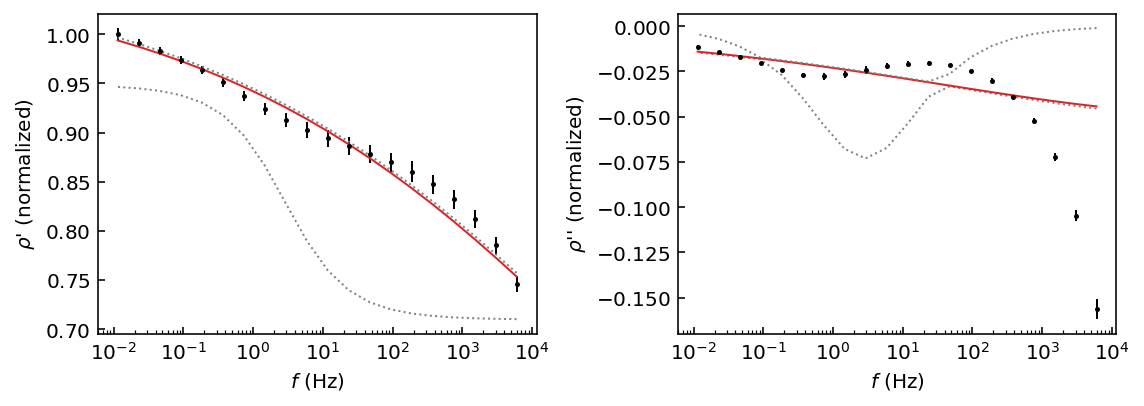

In [4]:
# Plot the fit by discarding the first 500 steps
fig = model.plot_fit(discard=500)

Not good. clearly, our data is not well represented by the default ColeCole `n_modes=1`. In fact, we see two bumps in the imaginary part of the resistivity spectra (the first at 1 Hz and the second at > 10 kHz. Let's redefine our model with `n_modes = 2` and `nwalkers = 64`. We run the simulation with more walkers because the number of parameters to solve has increased.

In [5]:
# Add the n_modes = 2 argument.
model = PeltonColeCole(filepath=filepath, 
                       nwalkers=64, 
                       nsteps=1000, 
                       n_modes=2)
# Fit model to data
model.fit()

100%|██████████| 1000/1000 [00:02<00:00, 435.49it/s]


Let's check the traces again. We expect two values for $m$, $\log \tau$ and $c$ because we have two Cole-Cole modes.

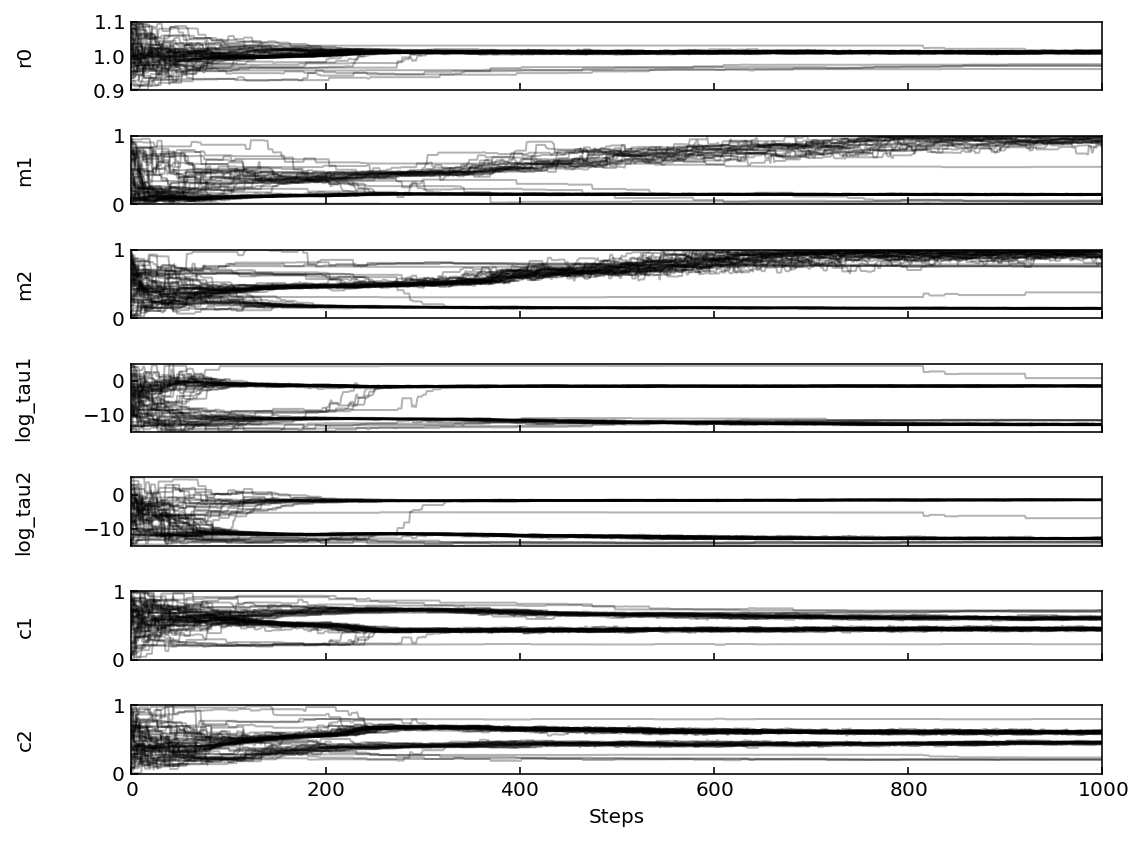

In [6]:
fig = model.plot_traces()

This is quite interesting. It's not even worth yet to look at the fit quality, because the parameter traces tell us that there are at least two possible solutions to the inverse problem. This is because both Cole-Cole modes are interchangeable -- meaning that mode 1 can take on the parameters of mode 2 and vice versa. We will now see how to fix this problem by adjusting the parameter boundaries.

First we note that $\log \tau_1$ has two solutions: one around 0 and another around -15. The same is true for $\log \tau_2$. We will fix $\log \tau_1$ so that its values is constrained between -5 and 0, and fix the $\log \tau_2$ to be constrained between -10 and -15.

In [7]:
# Adjust the boundaries
model.params.update(log_tau1=[-5, 5], log_tau2=[-15, -10])

Next we fit the model using these new boundaries and visualize the traces.

100%|██████████| 1000/1000 [00:02<00:00, 356.54it/s]


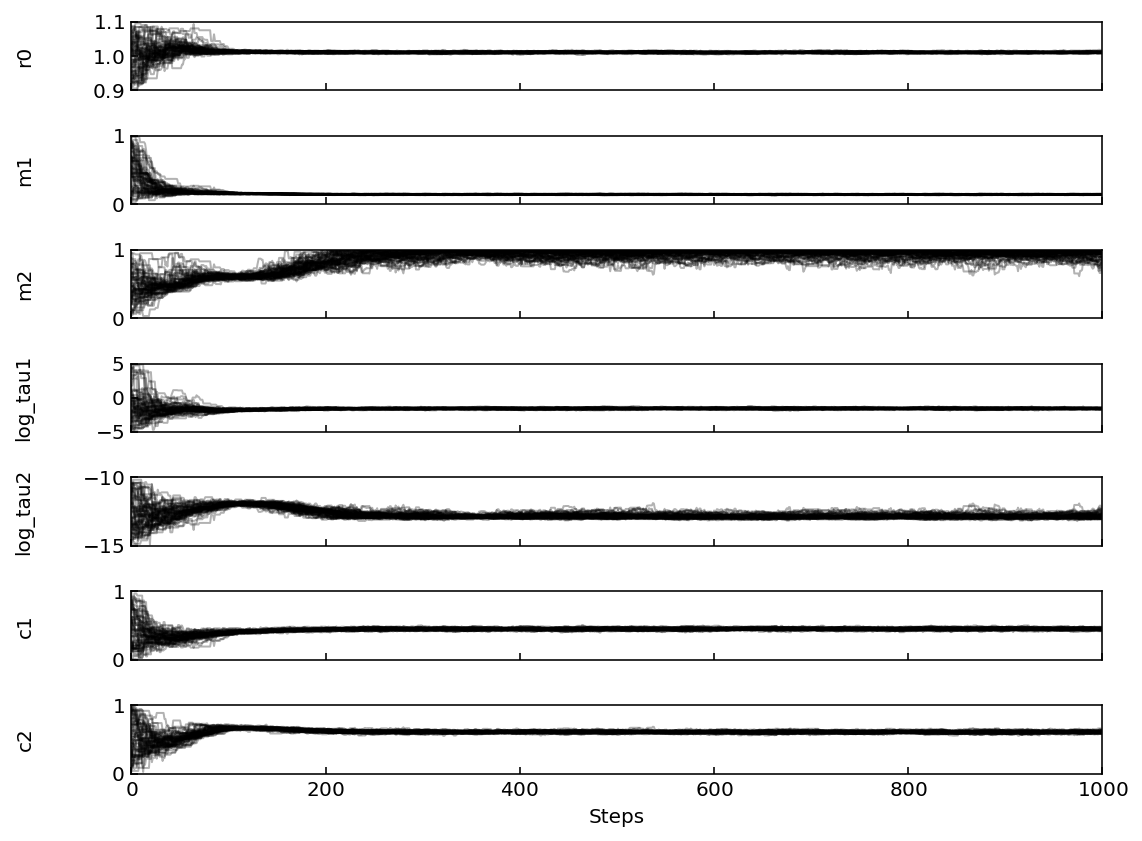

In [8]:
model.fit()
fig = model.plot_traces()

Amazing! The stricter priors have allowed all 64 walkers to find a unique solution. With these improved parameter chains the fit quality should be improved. Let's plot the fit quality while discarding the first 1000 steps.

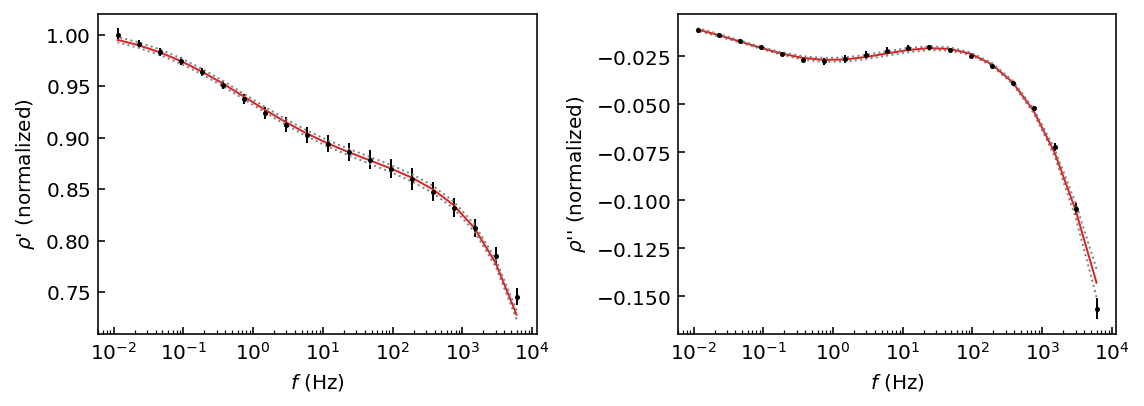

In [9]:
# Extract the chain 
chain = model.get_chain(discard=500, thin=10, flat=True)

# Plot the fit by discarding the first 1000 steps
fig = model.plot_fit(chain)

The adjustment is satisfying, and the 95% HPD reasonable if we consider the relatively small measurement error bars. Let's inspect the mean parameters and their uncertainties.

In [10]:
# Use this utility function to nicely print parameter values 
# for the Pelton model with LaTeX

# Print the mean and std of the parameters after discarding burn-in samples
values = model.get_param_mean(chain)
uncertainties = model.get_param_std(chain)

model.print_latex_parameters(model.param_names, values, uncertainties)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

It looks like the parameters are very well resolved, and due to the small data error bars the uncertainties on the Pelton parameters are also very small (but you should still not neglect them). Feel free to visualize the posterior distribution of the Pelton model with the `plot_corner` method, which shows that the $m_2$ parameter has accumulated at $m_2 \to 1$. This tells us that although the fit quality is good, the Pelton model does not explain well our data set.

## Large uncertainties

Let's now consider a different rock sample where the measurement uncertainty is relatively lage (`K389172`), we apply the same method we did previously and put it all together in the following cell:

100%|██████████| 1000/1000 [00:02<00:00, 366.72it/s]


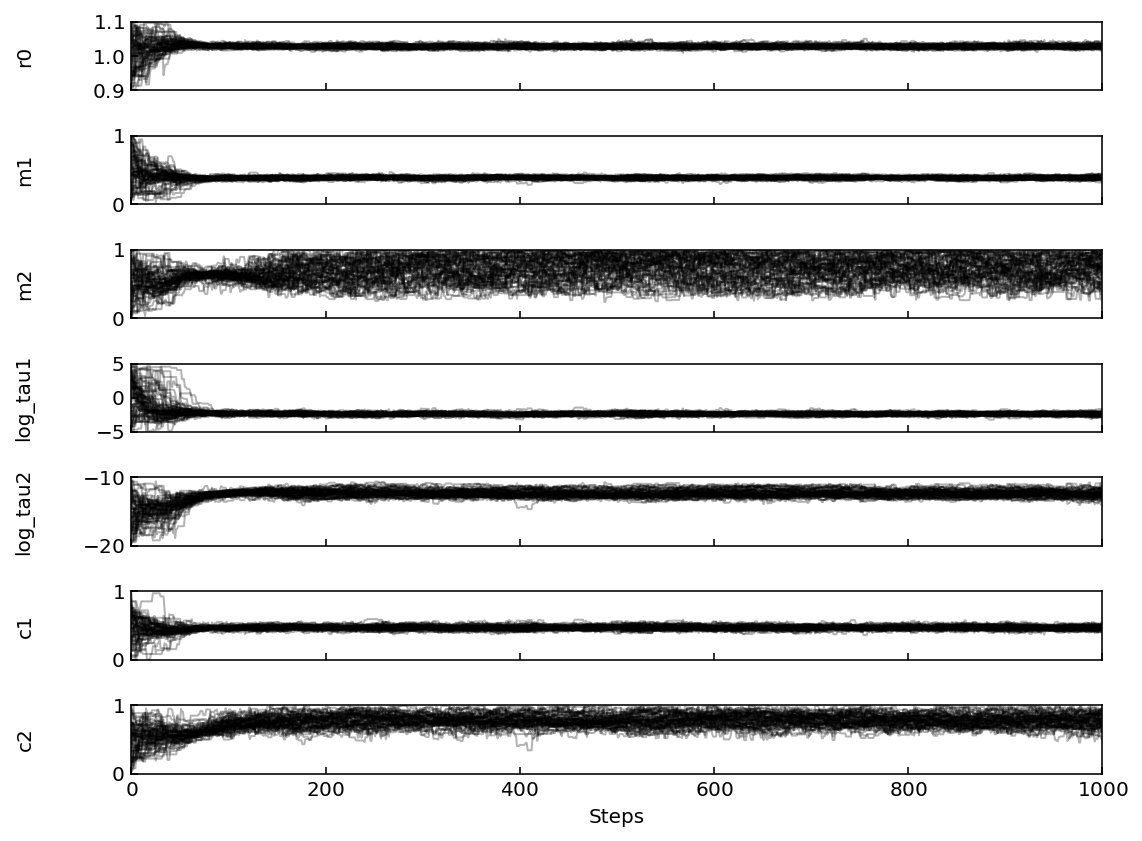

In [11]:
# Define MCMC parameters and ColeCole model with
# one of the example data files in the BISIP package
model = PeltonColeCole(filepath=data_files['SIP-K389172'], 
                       nwalkers=64, 
                       nsteps=1000, 
                       n_modes=2)

# Adjust the boundaries
model.params.update(log_tau1=[-5, 5], log_tau2=[-20, -10])

# Fit model to data
model.fit()
fig = model.plot_traces()

The inversion has reached a unique solution, but due to the large error bars on the data we can see from the traces that the parameters of mode 2 ($m_2$, $\log \tau_2$, $c_2$) are quite ill-defined. 

## Weak polarization

Finally, let's consider rock sample `K389176`, where the Cole-Cole modes are not well defined in the data (i.e. where the phase shift spectrum shows a relatively flat response.

100%|██████████| 1000/1000 [00:02<00:00, 393.54it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

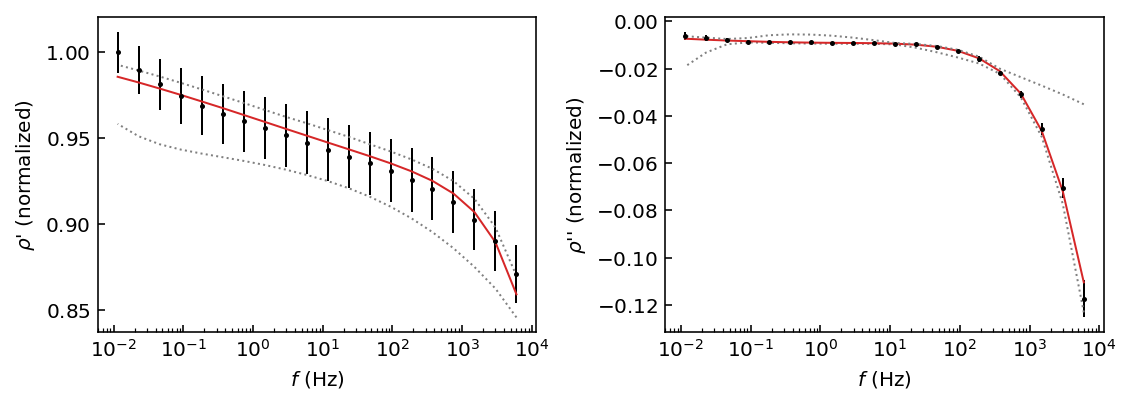

In [12]:
# Define MCMC parameters and ColeCole model with
# one of the example data files in the BISIP package
model = PeltonColeCole(filepath=data_files['SIP-K389176'],
                       nwalkers=64, 
                       nsteps=1000, 
                       n_modes=2)

# Adjust the boundaries
model.params.update(log_tau1=[-5, 5], log_tau2=[-20, -10])

# Fit model to data
model.fit()

# Plot fit
fig = model.plot_fit(discard=500)

# Print the mean and std of the parameters after discarding burn-in samples
values = model.get_param_mean(discard=500)
uncertainties = model.get_param_std(discard=500)
model.print_latex_parameters(model.param_names, values, uncertainties, decimals=2)

Inspect the traces and fit figures, you will notice that the data is well fitted by the double Pelton model. However, we note that due to the weak polarization (flat response) in the low-frequency range, the $\log \tau_1$ parameter is extremely ill-defined (the relative error is more than 100%!). This is because the absence of a clear polarization peak (low values of $c$) can't be explained with Cole-Cole type models, which expect a well-defined local maximum in the phase shift spectrum. This is discussed in more detail in [Bérubé et al. (2017)](https://doi.org/10.1016/j.cageo.2017.05.001).

## Conclusions

From this experiment, we learned that the Pelton Cole-Cole model modes are interchangeable, and that to avoid this problem we must fix the $\log \tau_k$ parameters to take on boundaries that do not overlap. It also appears that the $m_2$ parameter is often not well resolved because it has accumulated at its upper limit. This implies that even higher values of $m_2$ may explain our data better. However, because $m$ is defined in the interval $[0, 1]$ our results suggest that the Pelton Cole-Cole model may not explain well our data set, especially its high-frequency response. Finally, we saw that data error bars have a high impact of the quality of resolved Cole-Cole parameters, and that weak polarization responses will most certaintly yield ill-defined inversion parameters.